In [13]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shap

Read data in and clean

In [14]:
# Import csv file prices_prod
source_df = pd.read_csv('./Resources/prices_clim.csv', parse_dates=['date'], index_col= 'date' )
source_df.reset_index(inplace=True)
source_df.sort_index(inplace=True)
source_df.head()
source_df.dropna()

,date,avg_price,year_month,geography,type,prices_total_volume,units_4046,units_4225,units_4770,total_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,1/1/2017,Dallas/FtWorth,conventional,1247488.60,556814.80,343124.23,2551.41,344998.16,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,1/1/2017,Atlanta,organic,8244.17,1456.00,5316.57,0.00,1471.60,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,1/1/2017,Chicago,organic,47561.03,52.69,43587.09,0.00,3921.25,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,1/1/2017,GrandRapids,organic,1095.77,84.21,738.23,0.00,273.33,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,1/1/2017,SouthCentral,conventional,6207638.50,4020198.09,957479.68,23685.51,1206275.22,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20405,2020-09-06,1.09,9/1/2020,NewYork,conventional,2454855.84,72130.55,1564749.80,2680.49,815295.00,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,9/1/2020,Baltimore/Washington,conventional,1157352.09,114543.47,463911.16,4732.33,574165.13,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,9/1/2020,NorthernNewEngland,conventional,599275.15,17186.93,432244.14,78.56,149765.52,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20408,2020-09-06,0.76,9/1/2020,Indianapolis,conventional,317028.79,103261.66,21501.55,3538.51,188727.07,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [15]:
# Drop the non-beneficial columns, 'status' and 'prod'.
prices_df = source_df.drop(['year_month', 'prices_total_volume', 'total_bags'],axis=1)
prices_df

,date,avg_price,geography,type,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,conventional,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,Atlanta,organic,1456.00,5316.57,0.00,0.00,1471.60,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,organic,52.69,43587.09,0.00,3921.25,0.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,organic,84.21,738.23,0.00,263.33,10.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,conventional,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20405,2020-09-06,1.09,NewYork,conventional,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,conventional,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,conventional,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20408,2020-09-06,0.76,Indianapolis,conventional,103261.66,21501.55,3538.51,177417.16,9669.39,1640.52,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [16]:
# Drop rows that are totals for included sub areas and thus duplicates
prices_df = prices_df.drop(prices_df[(source_df.geography == 'California') | 
                                (prices_df.geography == 'Southeast') |
                                   (source_df.geography == 'TotalUS') |
                                   (source_df.geography == 'Midsouth') |
                                   (source_df.geography == 'Northeast') |
                                   (source_df.geography == 'Southeast') |
                                   (source_df.geography == 'West') ].index)
prices_df

,date,avg_price,geography,type,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,conventional,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
1,2017-01-08,1.74,Atlanta,organic,1456.00,5316.57,0.00,0.00,1471.60,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,organic,52.69,43587.09,0.00,3921.25,0.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,organic,84.21,738.23,0.00,263.33,10.00,0.00,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,conventional,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20404,2020-09-06,1.65,Charlotte,organic,87.19,3662.19,40.24,9875.50,970.84,0.00,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20405,2020-09-06,1.09,NewYork,conventional,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,conventional,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,conventional,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [17]:
# Correct the type catagory
prices_df.loc[prices_df['type'] == 'conventional ', 'type'] = 'conventional'
prices_df.groupby('type').size()

type
conventional    9072
organic         9070
dtype: int64

In [18]:
lstmconv_df = prices_df.loc[prices_df['type'] == 'conventional'].copy()
lstmconv_df.drop(['type'],axis=1, inplace=True)
lstmconv_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
5,2017-01-08,1.40,Miami/FtLauderdale,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
9,2017-01-22,1.04,Roanoke,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
10,2017-01-29,1.00,StLouis,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20405,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [19]:
lstmorg_df = prices_df.loc[prices_df['type'] == 'organic'].copy()
lstmorg_df.drop(['type'],axis=1, inplace=True)
lstmorg_df

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
1,2017-01-08,1.74,Atlanta,1456.00,5316.57,0.00,0.00,1471.60,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
2,2017-01-22,1.51,Chicago,52.69,43587.09,0.00,3921.25,0.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
3,2017-01-02,1.79,GrandRapids,84.21,738.23,0.00,263.33,10.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
7,2017-01-02,1.46,StLouis,1662.86,413.93,0.00,716.11,3057.90,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
8,2017-01-02,1.40,Houston,7550.89,58.71,0.00,2499.86,0.00,0.0,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20398,2020-09-06,1.93,Boston,144.34,2215.12,0.00,32786.65,1029.05,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20399,2020-09-06,1.76,Boise,0.00,680.04,0.00,1696.67,4806.52,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20401,2020-09-06,1.63,Tampa,115.22,0.00,0.00,3427.70,1438.89,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20402,2020-09-06,1.69,Baltimore/Washington,662.61,4353.40,6.56,30992.62,5476.07,0.0,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [20]:
# Compare prices to price information
#g = sns.PairGrid(source_df[['avg_price', 'units_4046', 'units_4225',
#                           'units_4770', 's_bags', 'l_bags', 'xl_bags']])
#g.map(sns.scatterplot)

In [21]:
# Compare prices to climate information
#g = sns.PairGrid(source_df[['avg_price', 'pcp', 'tavg', 'pdsi',
#       'phdi', 'zndx', 'pmdi', 'cdd', 'sp01', 'sp02', 'sp03', 'sp06', 'sp09',
#       'sp12', 'sp24', 'tmin', 'tmax', ]])
#g.map(sns.scatterplot)

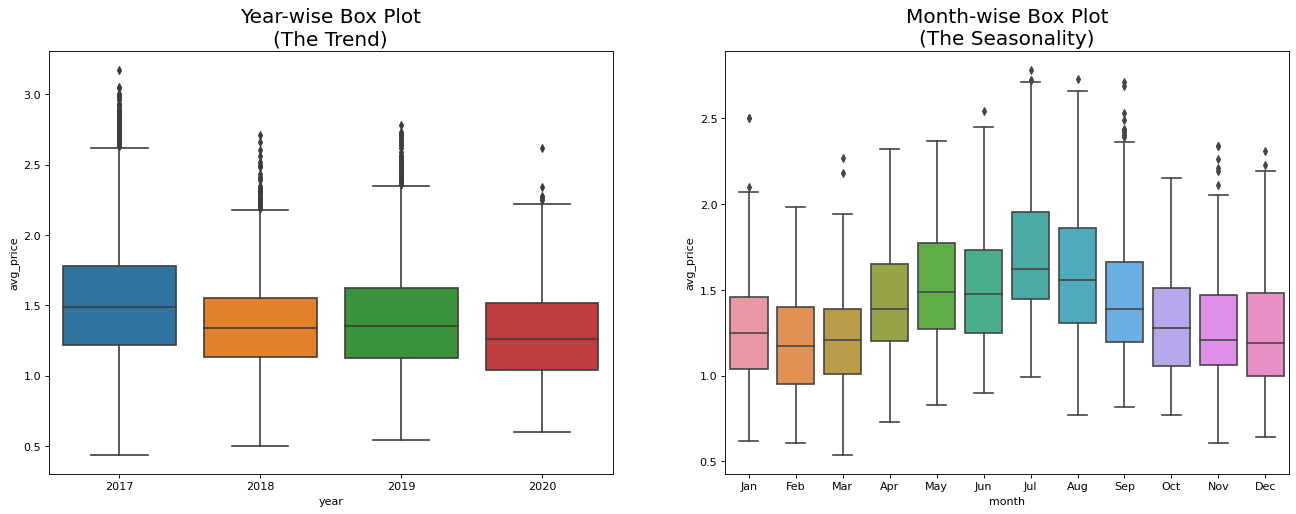

In [22]:
# Prepare data
prices_df['year'] = [d.year for d in prices_df.date]
prices_df['month'] = [d.strftime('%b') for d in prices_df.date]
years = prices_df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='avg_price', data=prices_df, ax=axes[0])
sns.boxplot(x='month', y='avg_price', data=prices_df.loc[~prices_df.year.isin([2017,2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

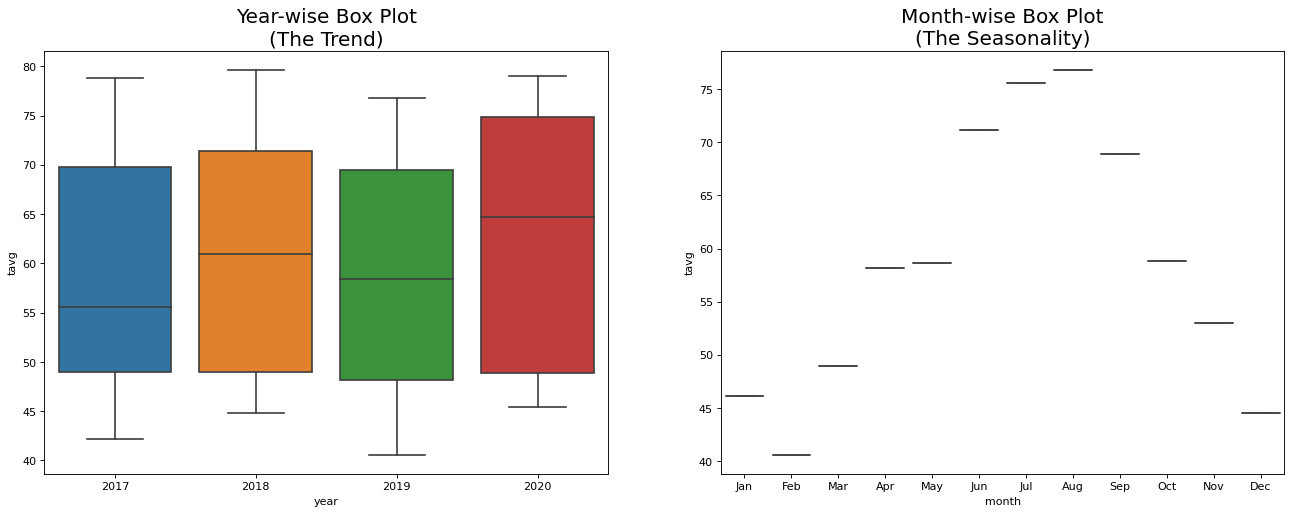

In [23]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='tavg', data=prices_df, ax=axes[0])
sns.boxplot(x='month', y='tavg', data=prices_df.loc[~prices_df.year.isin([2017, 2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

LSTM Data Preparation

In [24]:
lstmconv_df.to_csv('lstm_cleaned_conv_prices_clim.csv')
lstmorg_df.to_csv('lstm_cleaned_org_prices_clim.csv')

Data pipeline including lags

In [25]:
# read in data
dataset = pd.read_csv('lstm_cleaned_conv_prices_clim.csv', header=0, index_col=0)
dataset

,date,avg_price,geography,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags,pcp,...,cdd,sp01,sp02,sp03,sp06,sp09,sp12,sp24,tmin,tmax
0,2017-01-08,0.78,Dallas/FtWorth,556814.80,343124.23,2551.41,341681.22,3247.62,69.32,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
4,2017-01-22,0.74,SouthCentral,4020198.09,957479.68,23685.51,1066264.87,128528.14,11482.21,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
5,2017-01-08,1.40,Miami/FtLauderdale,209904.22,121128.25,293.18,85738.78,105206.85,6.94,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
9,2017-01-22,1.04,Roanoke,48905.14,46802.42,142.99,66764.36,883.94,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
10,2017-01-29,1.00,StLouis,80253.19,15081.96,159.98,63464.66,33402.39,0.00,9.92,...,0,1.78,1.59,1.43,1.77,1.69,1.29,0.7,34.0,50.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20403,2020-09-06,1.30,Albany,8926.79,104185.45,118.00,17394.83,8510.43,577.36,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20405,2020-09-06,1.09,NewYork,72130.55,1564749.80,2680.49,583789.55,228511.87,2993.58,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20406,2020-09-06,1.00,Baltimore/Washington,114543.47,463911.16,4732.33,245117.49,322831.54,6216.10,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0
20407,2020-09-06,1.14,NorthernNewEngland,17186.93,432244.14,78.56,85134.26,63061.88,1569.38,0.04,...,268,-1.68,-1.67,-1.95,0.03,-1.25,-1.12,0.0,59.4,89.0


In [31]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# read in data
dataset = pd.read_csv('lstm_cleaned_org_prices_clim.csv', header=0, index_col=0)

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, 261:,], axis=1, inplace=True)
reframed.drop(reframed.index[0], inplace=True)
print(reframed)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.476190   0.010328   0.016113   0.000000   0.000000   0.007420   
2      0.391941   0.000374   0.132100   0.000000   0.005080   0.000000   
3      0.494505   0.000597   0.002237   0.000000   0.000341   0.000050   
4      0.373626   0.011795   0.001254   0.000000   0.000928   0.015418   
5      0.351648   0.053560   0.000178   0.000000   0.003239   0.000000   
...         ...        ...        ...        ...        ...        ...   
4017   0.406593   0.002367   0.001113   0.000000   0.014865   0.000807   
4018   0.681319   0.001880   0.007243   0.000000   0.000390   0.008460   
4019   0.443223   0.000125   0.001317   0.000000   0.002386   0.000218   
4020   0.391941   0.000452   0.011892   0.007319   0.011343   0.023636   
4021   0.395604   0.039287   0.011225   0.000000   0.014354   0.001919   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var252(t-1)  \
1           0.0        1.0   0.000000   

In [34]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var252(t-1),var253(t-1),var254(t-1),var255(t-1),var256(t-1),var257(t-1),var258(t-1),var259(t-1),var260(t-1),var1(t)
1,0.476190,0.010328,0.016113,0.000000,0.000000,0.007420,0.0,1.0,0.000000,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391941
2,0.391941,0.000374,0.132100,0.000000,0.005080,0.000000,0.0,1.0,0.000000,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.494505
3,0.494505,0.000597,0.002237,0.000000,0.000341,0.000050,0.0,1.0,0.000000,0.870932,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.373626
4,0.373626,0.011795,0.001254,0.000000,0.000928,0.015418,0.0,1.0,0.000000,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351648
5,0.351648,0.053560,0.000178,0.000000,0.003239,0.000000,0.0,1.0,0.000000,0.870932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4017,0.406593,0.002367,0.001113,0.000000,0.014865,0.000807,0.0,0.0,0.914439,0.161616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.681319
4018,0.681319,0.001880,0.007243,0.000000,0.000390,0.008460,0.0,0.0,0.914439,0.161616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.443223
4019,0.443223,0.000125,0.001317,0.000000,0.002386,0.000218,0.0,0.0,0.914439,0.161616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391941
4020,0.391941,0.000452,0.011892,0.007319,0.011343,0.023636,0.0,0.0,0.914439,0.161616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395604


In [35]:
# split into train and test sets
value = reframed
n_train = 3216 # 2018 through 2019
n_features = 261
train = value[:n_train].values
test = value[n_train:].values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3216, 1, 260) (3216,) (805, 1, 260) (805,)


## Instanciate and fit LSTM model with lags

Epoch 1/100
65/65 - 1s - loss: 0.1403 - val_loss: 0.2163
Epoch 2/100
65/65 - 0s - loss: 0.1577 - val_loss: 0.2958
Epoch 3/100
65/65 - 0s - loss: 0.1295 - val_loss: 0.3064
Epoch 4/100
65/65 - 0s - loss: 0.1506 - val_loss: 0.1864
Epoch 5/100
65/65 - 0s - loss: 0.1256 - val_loss: 0.0873
Epoch 6/100
65/65 - 0s - loss: 0.1120 - val_loss: 0.0901
Epoch 7/100
65/65 - 0s - loss: 0.1202 - val_loss: 0.1075
Epoch 8/100
65/65 - 0s - loss: 0.1221 - val_loss: 0.0757
Epoch 9/100
65/65 - 0s - loss: 0.1168 - val_loss: 0.0904
Epoch 10/100
65/65 - 0s - loss: 0.1106 - val_loss: 0.1406
Epoch 11/100
65/65 - 0s - loss: 0.1076 - val_loss: 0.1714
Epoch 12/100
65/65 - 0s - loss: 0.1081 - val_loss: 0.1455
Epoch 13/100
65/65 - 0s - loss: 0.1076 - val_loss: 0.1097
Epoch 14/100
65/65 - 0s - loss: 0.1043 - val_loss: 0.0783
Epoch 15/100
65/65 - 0s - loss: 0.1040 - val_loss: 0.0716
Epoch 16/100
65/65 - 0s - loss: 0.1058 - val_loss: 0.0729
Epoch 17/100
65/65 - 0s - loss: 0.1066 - val_loss: 0.0705
Epoch 18/100
65/65 - 0s

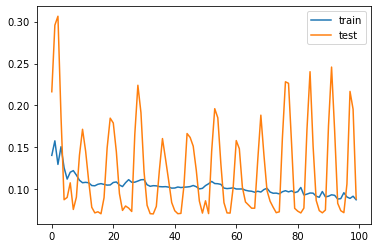

Test RMSE: 0.301


In [36]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(
    test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [38]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(inv_yhat.shape,inv_y.shape )

(2856, 756) (2856,) (0, 756) (0,)
(805,) (805,)


In [17]:
# loss, accuracy = model.evaluate(train_X, train_y)

Multiple Lag Model

(2284, 522) (2284,) (573, 522) (573,)
(2284, 2, 261) (2284,) (573, 2, 261) (573,)
Epoch 1/100
32/32 - 1s - loss: 0.0261 - val_loss: 0.0663
Epoch 2/100
32/32 - 0s - loss: 0.0128 - val_loss: 0.0608
Epoch 3/100
32/32 - 0s - loss: 0.0111 - val_loss: 0.0710
Epoch 4/100
32/32 - 0s - loss: 0.0144 - val_loss: 0.0572
Epoch 5/100
32/32 - 0s - loss: 0.0116 - val_loss: 0.0522
Epoch 6/100
32/32 - 0s - loss: 0.0116 - val_loss: 0.0514
Epoch 7/100
32/32 - 0s - loss: 0.0111 - val_loss: 0.0740
Epoch 8/100
32/32 - 0s - loss: 0.0255 - val_loss: 0.0566
Epoch 9/100
32/32 - 0s - loss: 0.0228 - val_loss: 0.0549
Epoch 10/100
32/32 - 0s - loss: 0.0138 - val_loss: 0.0624
Epoch 11/100
32/32 - 0s - loss: 0.0119 - val_loss: 0.0604
Epoch 12/100
32/32 - 0s - loss: 0.0115 - val_loss: 0.0507
Epoch 13/100
32/32 - 0s - loss: 0.0140 - val_loss: 0.0518
Epoch 14/100
32/32 - 0s - loss: 0.0139 - val_loss: 0.0521
Epoch 15/100
32/32 - 0s - loss: 0.0138 - val_loss: 0.0456
Epoch 16/100
32/32 - 0s - loss: 0.0084 - val_loss: 0.0482

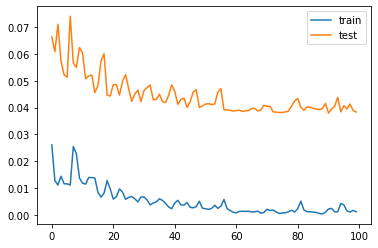

ValueError: non-broadcastable output operand with shape (573,1) doesn't match the broadcast shape (573,189)

In [69]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('lstm_cleaned_org_prices.csv', header=0, index_col=0)
values = dataset.values

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# specify the number of lag times
n_times = 2
n_features = 261

# frame as supervised learning
reframed = series_to_supervised(scaled, n_times, 1)
#print(reframed.shape)
 
# drop columns we don't want to predict
#reframed.drop(reframed.iloc[:, 168:,], axis=1, inplace=True)
#reframed.drop(reframed.index[0], inplace=True)
#print(reframed.shape)
  
# split into train and test sets
values = reframed.values
n_train =  2284 # 2018 through 2019 3216
train = values[:n_train, :]
test = values[n_train:, :]
#print(train.shape, test.shape)

#split into input and outputs
n_obs = n_times * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_times, n_features))
test_X = test_X.reshape((test_X.shape[0], n_times, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_times*n_features))
#print(yhat.shape, test_X.shape)

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 523:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 523:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [72]:
reframed

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var180(t),var181(t),var182(t),var183(t),var184(t),var185(t),var186(t),var187(t),var188(t),var189(t)
2,0.420792,0.000405,0.001249,0.000000,0.021223,0.000029,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.415842,0.003775,0.012714,0.000000,0.038431,0.028304,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.227723,0.012256,0.030192,0.008938,0.345809,0.000058,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.534653,0.000397,0.002876,0.000000,0.002649,0.008852,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.603960,0.000135,0.008196,0.000000,0.122561,0.019765,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,0.316832,0.012053,0.007418,0.000000,0.045005,0.000186,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,0.465347,0.142520,0.089023,0.000000,0.325463,0.007176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2856,0.410891,0.000127,0.002977,0.000000,0.007244,0.009419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2857,0.247525,0.011666,0.000006,0.000000,0.043424,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
# split into train and test sets
print(train.shape, test.shape)
#split into input and outputs
print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# make a prediction
print(yhat.shape, test_X.shape)
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 379:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 379:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
print(inv_y.shape)





(2284, 567) (573, 567)
(2284, 2, 261) (2284,) (573, 522) (573,)
(2284, 2, 261) (2284,) (573, 522) (573,)
(573, 1) (573, 522)
(573, 1)
(805,)


In [71]:
test_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [68]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2284, 2, 261) (2284,) (573, 522) (573,)


In [67]:
print(yhat.shape, inv_y.shape)

(573, 1) (805,)
